In [ ]:
# ! unzip '/content/drive/MyDrive/Anurag/nbme-score-clinical-patient-notes.zip' -d '/content/drive/MyDrive/Anurag/nbme-score-clinical-patient-notes'

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import pickle
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from tqdm import tqdm
from nltk import sent_tokenize
nltk.download('punkt')
import keras
from keras.layers import Input, LSTM, Dense, Embedding, Dropout
from keras.models import Model
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [3]:
features = pd.read_csv('/content/drive/MyDrive/Anurag/nbme-score-clinical-patient-notes/features.csv')
patient_notes = pd.read_csv('/content/drive/MyDrive/Anurag/nbme-score-clinical-patient-notes/patient_notes.csv')
submission = pd.read_csv('/content/drive/MyDrive/Anurag/nbme-score-clinical-patient-notes/sample_submission.csv')
test = pd.read_csv('/content/drive/MyDrive/Anurag/nbme-score-clinical-patient-notes/test.csv')
train = pd.read_csv('/content/drive/MyDrive/Anurag/nbme-score-clinical-patient-notes/train.csv')

In [4]:
features.head()

,feature_num,case_num,feature_text
0,0,0,Family-history-of-MI-OR-Family-history-of-myoc...
1,1,0,Family-history-of-thyroid-disorder
2,2,0,Chest-pressure
3,3,0,Intermittent-symptoms
4,4,0,Lightheaded


In [5]:
patient_notes.head()

,pn_num,case_num,pn_history
0,0,0,"17-year-old male, has come to the student heal..."
1,1,0,17 yo male with recurrent palpitations for the...
2,2,0,Dillon Cleveland is a 17 y.o. male patient wit...
3,3,0,a 17 yo m c/o palpitation started 3 mos ago; \...
4,4,0,17yo male with no pmh here for evaluation of p...


In [6]:
submission.head()

,id,location
0,00016_000,0 100
1,00016_001,NaN
2,00016_002,200 250;300 400
3,00016_003,NaN
4,00016_004,75 110


In [7]:
test.head()

,id,case_num,pn_num,feature_num
0,00016_000,0,16,0
1,00016_001,0,16,1
2,00016_002,0,16,2
3,00016_003,0,16,3
4,00016_004,0,16,4


In [8]:
train.head()

,id,case_num,pn_num,feature_num,annotation,location
0,00016_000,0,16,0,['dad with recent heart attcak'],['696 724']
1,00016_001,0,16,1,"['mom with ""thyroid disease']",['668 693']
2,00016_002,0,16,2,['chest pressure'],['203 217']
3,00016_003,0,16,3,"['intermittent episodes', 'episode']","['70 91', '176 183']"
4,00016_004,0,16,4,['felt as if he were going to pass out'],['222 258']


# Pre-Processing

In [88]:
mer_data = pd.merge(train, patient_notes, on=['pn_num', "case_num" ] , how='inner')
mer_data = pd.merge(df, features, on=['case_num', 'feature_num'], how = 'inner')

In [89]:
mer_data.head()

,id,case_num,pn_num,feature_num,annotation,location,pn_history,feature_text_x,nb of annotations,feature_text_y
0,00016_000,0,16,0,['dad with recent heart attcak'],['696 724'],HPI: 17yo M presents with palpitations. Patien...,Family-history-of-MI-OR-Family-history-of-myoc...,1,Family-history-of-MI-OR-Family-history-of-myoc...
1,00041_000,0,41,0,[],[],17 Y/O M CAME TO THE CLINIC C/O HEART POUNDING...,Family-history-of-MI-OR-Family-history-of-myoc...,0,Family-history-of-MI-OR-Family-history-of-myoc...
2,00046_000,0,46,0,['father: heart attack'],['824 844'],Mr. Cleveland is a 17yo M who was consented by...,Family-history-of-MI-OR-Family-history-of-myoc...,1,Family-history-of-MI-OR-Family-history-of-myoc...
3,00082_000,0,82,0,['Father MI'],['622 631'],17 yo M w/ no cardiac or arrhythmia PMH presen...,Family-history-of-MI-OR-Family-history-of-myoc...,1,Family-history-of-MI-OR-Family-history-of-myoc...
4,00100_000,0,100,0,['Dad-MI'],['735 741'],HPI: Dillon Cleveland is an otherwise healthy ...,Family-history-of-MI-OR-Family-history-of-myoc...,1,Family-history-of-MI-OR-Family-history-of-myoc...


In [90]:
mer_data.shape

(14300, 10)

In [91]:
mer_data['nb of annotations'] = mer_data.location.apply(lambda x:len(eval(x)))

In [92]:
mer_data['nb of annotations'].value_counts() / mer_data.shape[0] * 100

1    57.209790
0    30.762238
2     9.062937
3     2.006993
4     0.692308
5     0.188811
6     0.062937
7     0.006993
8     0.006993
Name: nb of annotations, dtype: float64

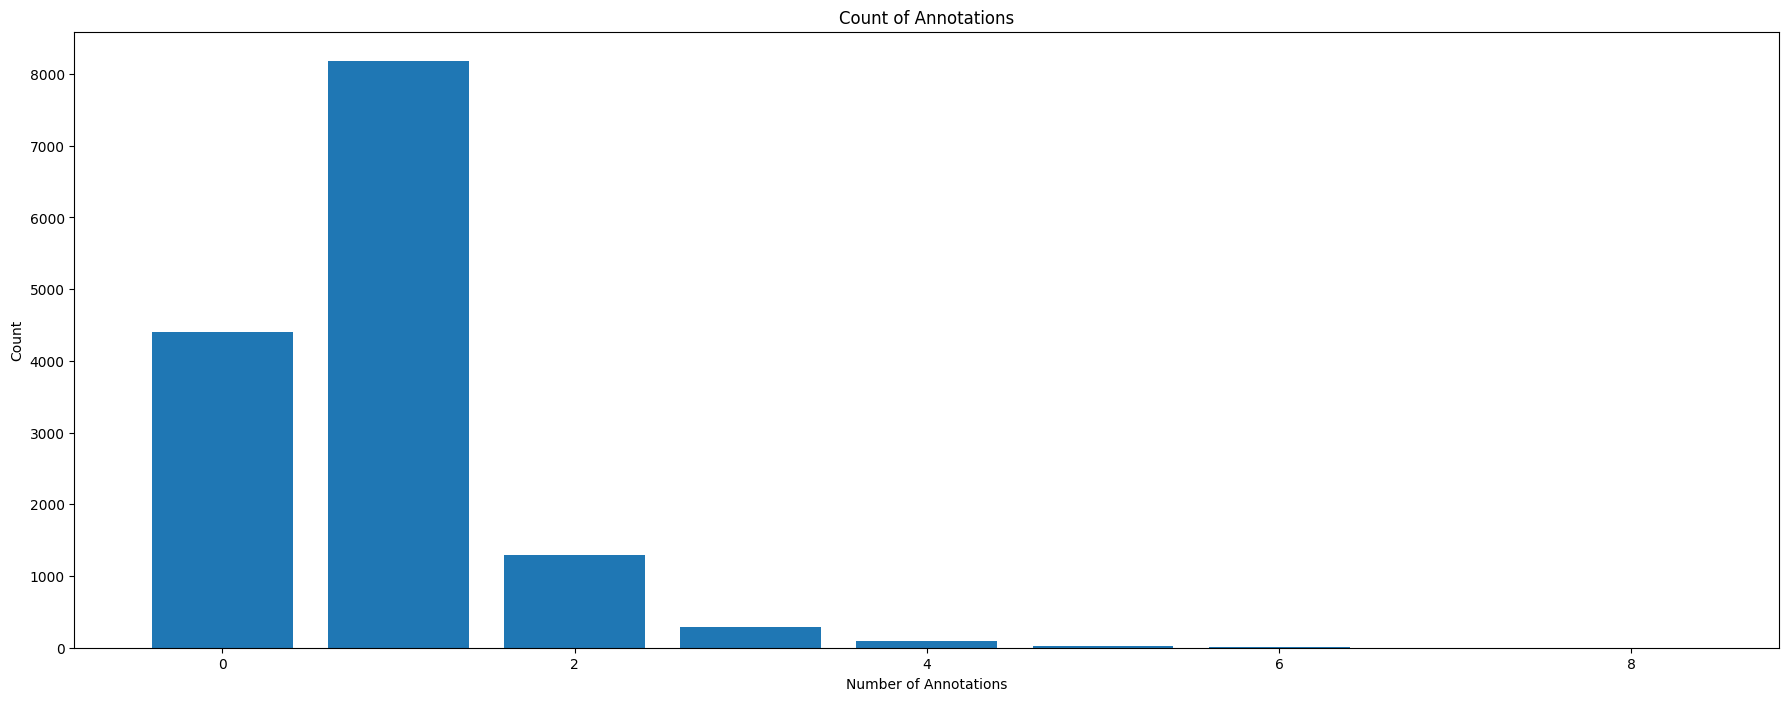

In [93]:
plt.figure(figsize=(22, 8))
plt.bar(mer_data['nb of annotations'].value_counts().index, mer_data['nb of annotations'].value_counts())
plt.xlabel('Number of Annotations')
plt.ylabel('Count')
plt.title('Count of Annotations')
plt.show()

In [15]:
new = mer_data[['id','annotation','location', 'pn_history', 'feature_text']]

- Data Prepration for NLP

In [17]:
feats = []
sents = []
labels = []
ids = []

for i in range(len(new)) :
    id_ = new.loc[i,'id']
    feat = new.loc[i,'feature_text']
    annot = eval(new.loc[i,'annotation'])
    loc = new.loc[i,'location']
    loc = [(int(l.split(' ')[0]), int(l.split(' ')[1])) for l in loc]
    notes_ = new.loc[i,'pn_history'].replace('\n', '.')

    # case with label = 1
    sents.extend(annot)
    feats.extend([feat]*len(annot))
    labels.extend([1]*len(annot))
    ids.extend([id_]*len(annot))

    # we loop over text before and after annotations
    for idx,(s, e) in enumerate(loc) :
        try :
            before_an = sent_tokenize(notes_[loc[idx-1][1]:s]) # do it for each annot
            after_an = sent_tokenize(notes_[e:loc[idx+1][0]])
        except :
            before_an = sent_tokenize(notes_[:s]) # do it for each annot
            after_an = sent_tokenize(notes_[e:])

        # case with label = 0
        sents.extend(before_an)
        sents.extend(after_an)
        n = len(before_an+after_an)
        feats.extend([feat]*n)
        labels.extend([0]*n)
        ids.extend([id_]*n)

In [18]:
med_recrd_final_data = pd.DataFrame(list(zip(ids, sents, feats, labels)),
               columns =['id','sent','feature', 'label'])
med_recrd_final_data.head()

,id,sent,feature,label
0,00016_000,dad with recent heart attcak,Family-history-of-MI-OR-Family-history-of-myoc...,1
1,00016_000,HPI: 17yo M presents with palpitations.,Family-history-of-MI-OR-Family-history-of-myoc...,0
2,00016_000,Patient reports 3-4 months of intermittent epi...,Family-history-of-MI-OR-Family-history-of-myoc...,0
3,00016_000,2 days ago during a soccer game had an episode...,Family-history-of-MI-OR-Family-history-of-myoc...,0
4,00016_000,"Of note patient endorses abusing adderall, pri...",Family-history-of-MI-OR-Family-history-of-myoc...,0


In [19]:
med_recrd_final_data.label.value_counts() / med_recrd_final_data.shape[0] * 100

0    90.862717
1     9.137283
Name: label, dtype: float64

In [20]:
def process(paragraph):
    ps = PorterStemmer()
    corpus = []

    # Keep just letters and turn them into lowercase
    paragraph = paragraph.replace('-', ' ')
    cleaned = re.sub('[^a-zA-Z]', ' ', paragraph)
    cleaned = cleaned.lower().split()

    # Remove stopwords + stemming
    cleaned = [ps.stem(word) for word in cleaned if word not in stopwords.words('english')]
    cleaned = ' '.join(cleaned)
    corpus.append(cleaned)

    return cleaned

med_recrd_final_data['sent'] = med_recrd_final_data['sent'].apply(process)
med_recrd_final_data['feature'] = med_recrd_final_data['feature'].apply(process)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [21]:
med_recrd_final_data.head()

,id,sent,feature,label
0,00016_000,dad recent heart attcak,famili histori mi famili histori myocardi infarct,1
1,00016_000,hpi yo present palpit,famili histori mi famili histori myocardi infarct,0
2,00016_000,patient report month intermitt episod heart be...,famili histori mi famili histori myocardi infarct,0
3,00016_000,day ago soccer game episod time chest pressur ...,famili histori mi famili histori myocardi infarct,0
4,00016_000,note patient endors abus adderal primarili stu...,famili histori mi famili histori myocardi infarct,0


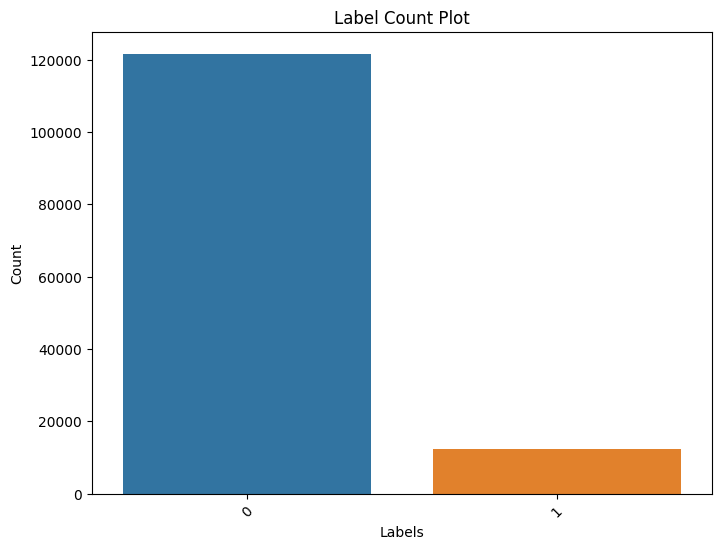

In [51]:
plt.figure(figsize=(8, 6))
sns.countplot(data=med_recrd_final_data, x='label')
plt.title('Label Count Plot')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

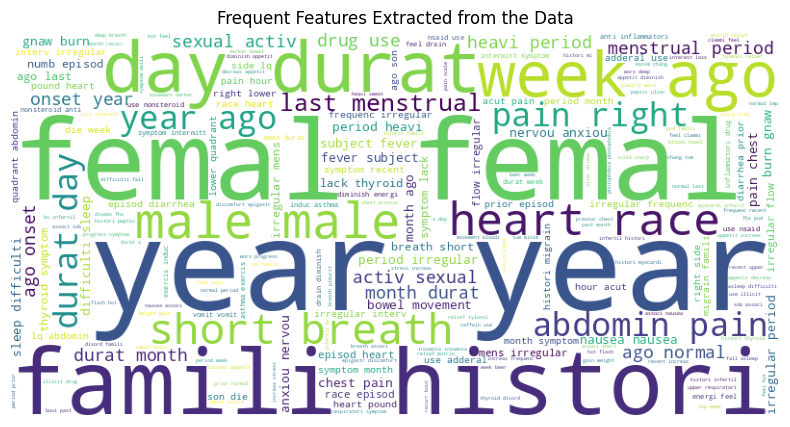

In [45]:
from wordcloud import WordCloud

text = " ".join(med_recrd_final_data['feature'])

# Create a WordCloud object
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud)
plt.axis("off")
plt.title("Frequent Features Extracted from the Data")
plt.show()


In [22]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(med_recrd_final_data['sent'], med_recrd_final_data['label'], test_size=0.2, random_state=42)

# Vectorize the text data using TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Machine Learning

In [23]:
# Train and evaluate an SVM classifier
svm_classifier = SVC()
svm_classifier.fit(X_train_tfidf, y_train)
svm_predictions = svm_classifier.predict(X_test_tfidf)

In [24]:
from sklearn.metrics import precision_score, recall_score, f1_score
svm_accuracy = accuracy_score(y_test, svm_predictions)
print(f'Accuracy from the SVC Model is:{svm_accuracy}')
svm_prec = precision_score(y_test, svm_predictions)
print(f'Precision from the SVC Model is:{svm_prec}')
svm_reca = recall_score(y_test, svm_predictions)
print(f'Recall from the SVC Model is:{svm_reca}')
svm_f1sc = f1_score(y_test, svm_predictions)
print(f'F1 Score from the SVC Model is:{svm_f1sc}')

Accuracy from the SVC Model is:0.9454049815153666
Precision from the SVC Model is:0.7874199184624345
Recall from the SVC Model is:0.5520620661494487
F1 Score from the SVC Model is:0.6490638502160345


In [33]:
from sklearn.metrics import classification_report, confusion_matrix
clf_rp = classification_report(y_test, svm_predictions)
print(f'Classification Report for SVM Model is:\n{clf_rp}')

Classification Report for SVM Model is:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97     24330
           1       0.79      0.55      0.65      2449

    accuracy                           0.95     26779
   macro avg       0.87      0.77      0.81     26779
weighted avg       0.94      0.95      0.94     26779



[]

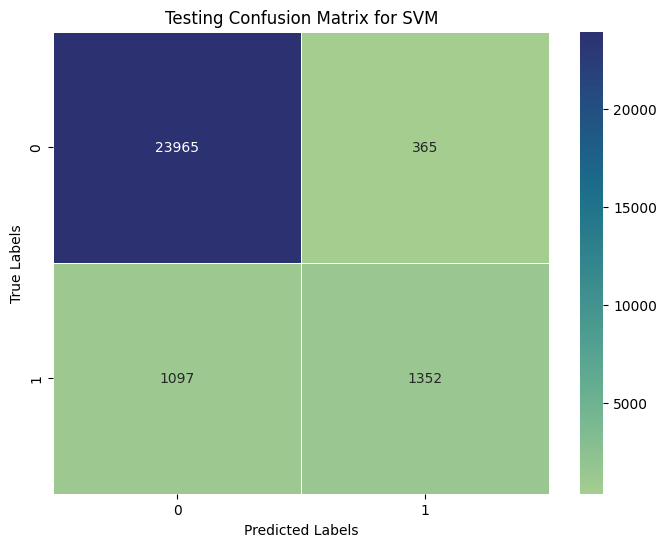

In [53]:
tst_cnmat = confusion_matrix(y_test, svm_predictions)
plt.rc('figure',figsize=(8,6))
sns.heatmap(tst_cnmat, annot=True, fmt='d', cmap='crest', linewidths=0.5)
plt.title('Testing Confusion Matrix for SVM')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.plot()

In [57]:
svm_trn_pred = svm_classifier.predict(X_train_tfidf)

In [64]:
svm_accuracy_trn = accuracy_score(y_train, svm_trn_pred)
print(f'Train Accuracy from the SVC Model is:{svm_accuracy_trn}')
svm_prec_trn = precision_score(y_train, svm_trn_pred)
print(f'Train Precision from the SVC Model is:{svm_prec_trn}')
svm_reca_trn = recall_score(y_train, svm_trn_pred)
print(f'Train Recall from the SVC Model is:{svm_reca_trn}')
svm_f1sc_trn = f1_score(y_train, svm_trn_pred)
print(f'Train F1 Score from the SVC Model is:{svm_f1sc_trn}')

Train Accuracy from the SVC Model is:0.9557752632758234
Train Precision from the SVC Model is:0.8277922077922077
Train Recall from the SVC Model is:0.6514052120592744
Train F1 Score from the SVC Model is:0.7290820703460108


In [65]:
clf_rp_trn = classification_report(y_train, svm_trn_pred)
print(f'Train Classification Report for SVM Model is:\n{clf_rp_trn}')

Train Classification Report for SVM Model is:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     97327
           1       0.83      0.65      0.73      9785

    accuracy                           0.96    107112
   macro avg       0.90      0.82      0.85    107112
weighted avg       0.95      0.96      0.95    107112



[]

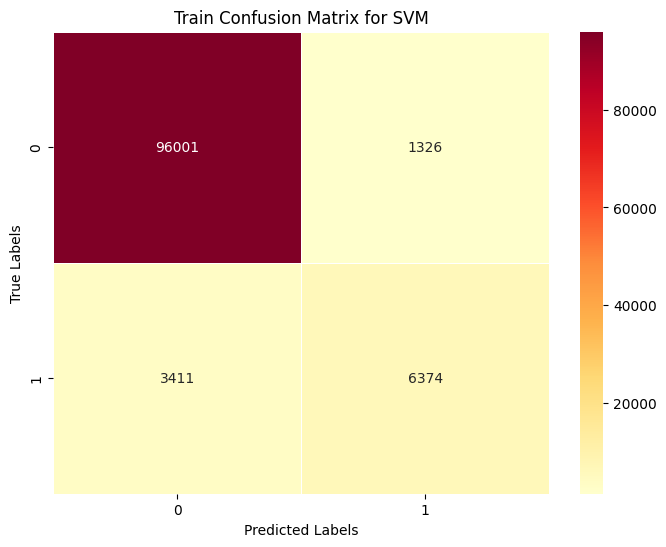

In [86]:
trn_cnmat = confusion_matrix(y_train, svm_trn_pred)
plt.rc('figure',figsize=(8,6))
sns.heatmap(trn_cnmat, annot=True, fmt='d', cmap='YlOrRd', linewidths=0.5)
plt.title('Train Confusion Matrix for SVM')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.plot()

In [28]:
# Train and evaluate a Random Forest classifier
rf_classifier = RandomForestClassifier()
rf_classifier.fit(X_train_tfidf, y_train)
rf_predictions = rf_classifier.predict(X_test_tfidf)

In [29]:
rf_accuracy = accuracy_score(y_test, rf_predictions)
print(f'Accuracy from the Random Forest Model is:{rf_accuracy}')
rf_prec = precision_score(y_test, rf_predictions)
print(f'Precision from the Random Forest Model is:{rf_prec}')
rf_reca = recall_score(y_test, rf_predictions)
print(f'Recall from the Random Forest Model is:{rf_reca}')
rf_f1sc = f1_score(y_test, rf_predictions)
print(f'F1 Score from the Random Forest Model is{rf_f1sc}')

Accuracy from the Random Forest Model is:0.9482056835580118
Precision from the Random Forest Model is:0.7706422018348624
Recall from the Random Forest Model is:0.6173948550428746
F1 Score from the Random Forest Model is0.6855588301972343


In [32]:
rf_clf_rp = classification_report(y_test, rf_predictions)
print(f'Classification Report for the Random Forest:\n{rf_clf_rp}')

Classification Report for the Random Forest:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97     24330
           1       0.77      0.62      0.69      2449

    accuracy                           0.95     26779
   macro avg       0.87      0.80      0.83     26779
weighted avg       0.94      0.95      0.95     26779



[]

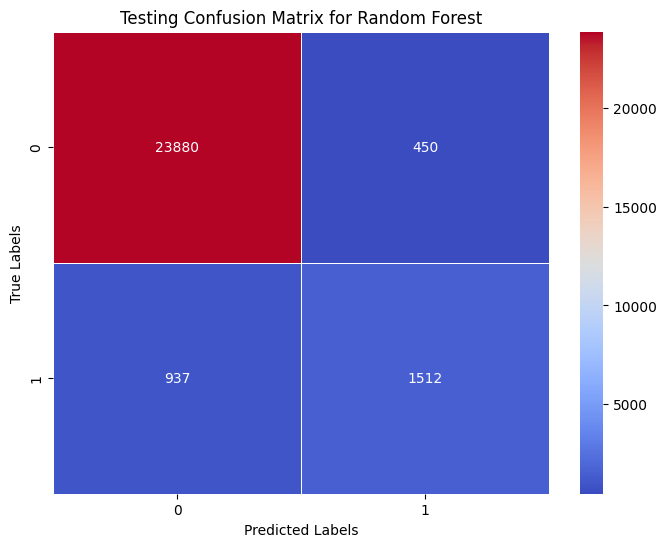

In [54]:
rf_tst_cnmat = confusion_matrix(y_test, rf_predictions)
plt.rc('figure',figsize=(8,6))
sns.heatmap(rf_tst_cnmat, annot=True, fmt='d', cmap='coolwarm', linewidth=0.5)
plt.title('Testing Confusion Matrix for Random Forest')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.plot()

In [63]:
ref_trn_pred = rf_classifier.predict(X_train_tfidf)

In [67]:
trn_rf_accuracy = accuracy_score(y_train, ref_trn_pred)
print(f'Train Accuracy from the Random Forest Model is:{trn_rf_accuracy}')
trn_rf_prec = precision_score(y_train, ref_trn_pred)
print(f'Train Precision from the Random Forest Model is:{trn_rf_prec}')
trn_rf_reca = recall_score(y_train, ref_trn_pred)
print(f'Train Recall from the Random Forest Model is:{trn_rf_reca}')
trn_rf_f1sc = f1_score(y_train, ref_trn_pred)
print(f'Train F1 Score from the Random Forest Model is{trn_rf_f1sc}')

Train Accuracy from the Random Forest Model is:0.966352976323848
Train Precision from the Random Forest Model is:0.8368392370572207
Train Recall from the Random Forest Model is:0.7846704138988247
Train F1 Score from the Random Forest Model is0.8099156118143459


In [68]:
rf_clf_rp = classification_report(y_train, ref_trn_pred)
print(f'Train Classification Report for the Random Forest:\n{rf_clf_rp}')

Train Classification Report for the Random Forest:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98     97327
           1       0.84      0.78      0.81      9785

    accuracy                           0.97    107112
   macro avg       0.91      0.88      0.90    107112
weighted avg       0.97      0.97      0.97    107112



[]

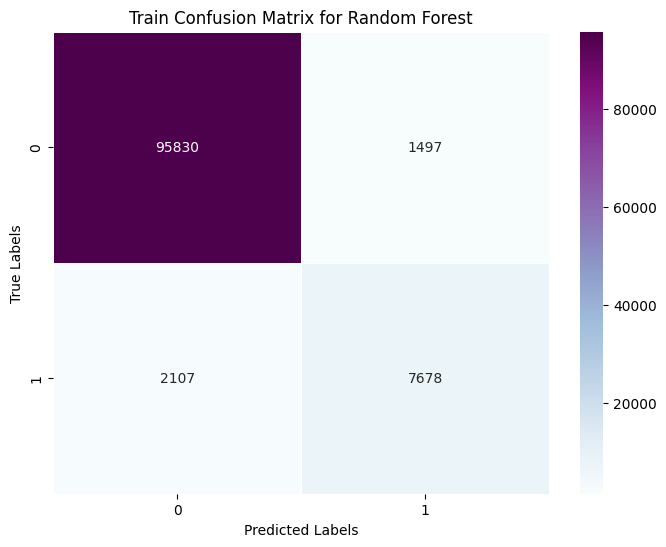

In [85]:
rf_trn_cnmat = confusion_matrix(y_train, ref_trn_pred)
plt.rc('figure',figsize=(8,6))
sns.heatmap(rf_trn_cnmat, annot=True, fmt='d', cmap='BuPu', linewidth=0.5)
plt.title('Train Confusion Matrix for Random Forest')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.plot()

# Deep Learning

In [34]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense
from sklearn.model_selection import train_test_split


# Preprocessing text data
max_words = 5000
max_sequence_length = 100
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(fornn['sent'])
sequences = tokenizer.texts_to_sequences(fornn['sent'])
X = pad_sequences(sequences, maxlen=max_sequence_length)
y = np.array(fornn['label'])

# Split data into training and testing sets
X_trn, X_tst, y_trn, y_tst = train_test_split(X, y, test_size=0.2, random_state=42)

# Create an LSTM model
model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=128, input_length=max_sequence_length))
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 128)          640000    
                                                                 
 lstm (LSTM)                 (None, 128)               131584    
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 771713 (2.94 MB)
Trainable params: 771713 (2.94 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [35]:
fit = model.fit(X_trn, y_trn, epochs=5, batch_size=300, validation_data=(X_tst, y_tst))

Epoch 1/5
358/358 [==============================] - 181s 501ms/step - loss: 0.2023 - accuracy: 0.9245 - val_loss: 0.1575 - val_accuracy: 0.9298
Epoch 2/5
358/358 [==============================] - 173s 483ms/step - loss: 0.1324 - accuracy: 0.9455 - val_loss: 0.1363 - val_accuracy: 0.9435
Epoch 3/5
358/358 [==============================] - 174s 487ms/step - loss: 0.1225 - accuracy: 0.9504 - val_loss: 0.1306 - val_accuracy: 0.9476
Epoch 4/5
358/358 [==============================] - 196s 548ms/step - loss: 0.1173 - accuracy: 0.9522 - val_loss: 0.1299 - val_accuracy: 0.9488
Epoch 5/5
358/358 [==============================] - 182s 509ms/step - loss: 0.1130 - accuracy: 0.9541 - val_loss: 0.1318 - val_accuracy: 0.9467


In [36]:
# Evaluate the model
tst_loss, tst_accu = model.evaluate(X_tst, y_tst)
print(f'Test loss: {tst_loss}, Test accuracy: {tst_accu}')

837/837 [==============================] - 27s 33ms/step - loss: 0.1318 - accuracy: 0.9467
Test loss: 0.13183501362800598, Test accuracy: 0.9467493295669556


In [37]:
trn_loss, trn_accu = model.evaluate(X_trn, y_trn)
print(f'Train Loss:{trn_loss}, Train Accuracy:{trn_accu}')

3348/3348 [==============================] - 142s 43ms/step - loss: 0.1104 - accuracy: 0.9535
Train Loss:0.11039309203624725, Train Accuracy:0.9534599184989929


In [38]:
y_lstm_pred = model.predict(X_tst)

837/837 [==============================] - 28s 33ms/step


In [39]:
threshold = 0.5  # You can change this threshold as needed
y_lstm_pred = (y_lstm_pred > threshold).astype(int)

array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]])

In [40]:
lstm_accu = accuracy_score(y_tst, y_lstm_pred)
print(f'Testing Accracy from the LSTM Model is:{lstm_accu}')
lstm_prec = precision_score(y_tst, y_lstm_pred)
print(f'Testing Precision from the LSTM Model is:{lstm_prec}')
lstm_reca = recall_score(y_tst, y_lstm_pred)
print(f'Testing Recall from the LSTM Model is:{lstm_reca}')
lstm_f1sc = f1_score(y_tst, y_lstm_pred)
print(f'Testing F1 Score from the LSTM Model is:{lstm_f1sc}')

Testing Accracy from the LSTM Model is:0.9467493184958363
Testing Precision from the LSTM Model is:0.8128440366972477
Testing Recall from the LSTM Model is:0.5426704777460187
Testing F1 Score from the LSTM Model is:0.6508325171400586


In [41]:
lstm_clf_rp = classification_report(y_tst, y_lstm_pred)
print(f'Testing CLassification Report for LSTM:\n{lstm_clf_rp}')

Testing CLassification Report for LSTM:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97     24330
           1       0.81      0.54      0.65      2449

    accuracy                           0.95     26779
   macro avg       0.88      0.77      0.81     26779
weighted avg       0.94      0.95      0.94     26779



[]

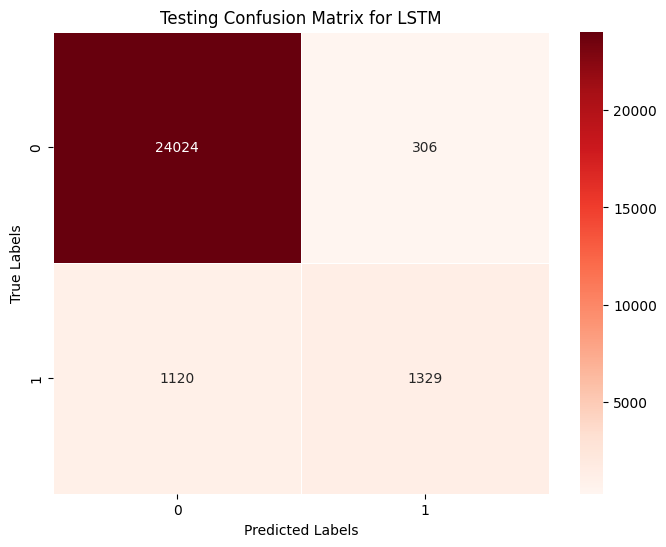

In [55]:
lstm_tst_cnmat = confusion_matrix(y_tst, y_lstm_pred)
plt.rc('figure',figsize=(8,6))
sns.heatmap(lstm_tst_cnmat, annot=True, fmt='d', cmap='Reds',linewidth=0.5)
plt.title('Testing Confusion Matrix for LSTM')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.plot()

In [73]:
lstm_trn_pred = model.predict(X_trn)

3348/3348 [==============================] - 169s 51ms/step


In [76]:
lstm_trn_pred = (lstm_trn_pred > threshold).astype(int)

In [77]:
trn_lstm_accu = accuracy_score(y_trn, lstm_trn_pred)
print(f'Train Accracy from the LSTM Model is:{trn_lstm_accu}')
trn_lstm_prec = precision_score(y_trn, lstm_trn_pred)
print(f'Train Precision from the LSTM Model is:{trn_lstm_prec}')
trn_lstm_reca = recall_score(y_trn, lstm_trn_pred)
print(f'Train Recall from the LSTM Model is:{trn_lstm_reca}')
trn_lstm_f1sc = f1_score(y_trn, lstm_trn_pred)
print(f'Train F1 Score from the LSTM Model is:{trn_lstm_f1sc}')

Train Accracy from the LSTM Model is:0.9534599297931138
Train Precision from the LSTM Model is:0.8436426116838488
Train Recall from the LSTM Model is:0.6021461420541645
Train F1 Score from the LSTM Model is:0.7027252668614705


In [78]:
lstm_clf_rp_trn = classification_report(y_trn, lstm_trn_pred)
print(f'Train CLassification Report for LSTM:\n{lstm_clf_rp_trn}')

Train CLassification Report for LSTM:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97     97327
           1       0.84      0.60      0.70      9785

    accuracy                           0.95    107112
   macro avg       0.90      0.80      0.84    107112
weighted avg       0.95      0.95      0.95    107112



[]

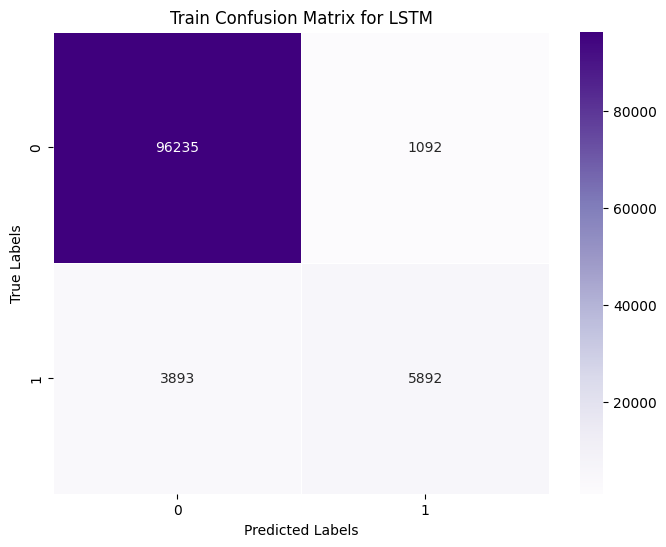

In [84]:
lstm_trn_cnmat = confusion_matrix(y_trn, lstm_trn_pred)
plt.rc('figure',figsize=(8,6))
sns.heatmap(lstm_trn_cnmat, annot=True, fmt='d', cmap='Purples',linewidth=0.5)
plt.title('Train Confusion Matrix for LSTM')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.plot()

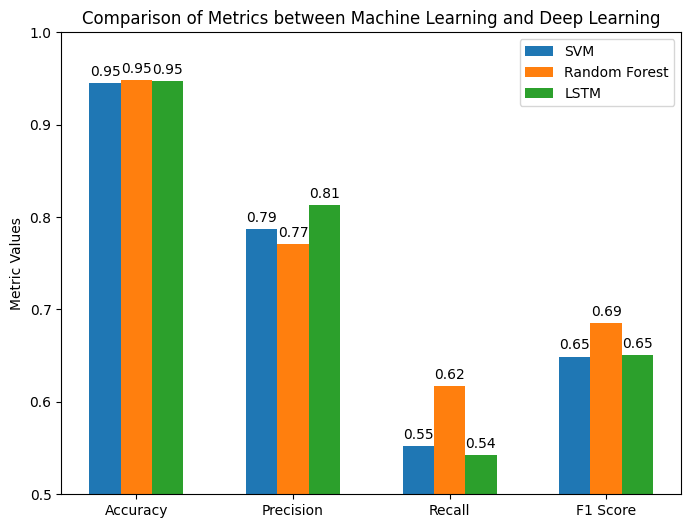

In [83]:
# Define the model names
model_names = ['SVM', 'Random Forest', 'LSTM']

# Define the metrics and their values for each model
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
model1_values = [svm_accuracy, svm_prec, svm_reca, svm_f1sc]  # Replace with your model 1's metric values
model2_values = [rf_accuracy, rf_prec, rf_reca, rf_f1sc]  # Replace with your model 2's metric values
model3_values = [lstm_accu, lstm_prec, lstm_reca, lstm_f1sc]  # Replace with your model 3's metric values

# Define the position of bars on the x-axis
x = np.arange(len(metrics))

# Set the width of the bars
width = 0.2

# Create the figure and axis objects
fig, ax = plt.subplots()

# Create bars for each model
bars_model1 = ax.bar(x - width, model1_values, width, label=model_names[0])
bars_model2 = ax.bar(x, model2_values, width, label=model_names[1])
bars_model3 = ax.bar(x + width, model3_values, width, label=model_names[2])

# Set the y-axis label
ax.set_ylabel('Metric Values')

# Set the title and custom x-axis labels
ax.set_title('Comparison of Metrics between Machine Learning and Deep Learning')
ax.set_xticks(x)
ax.set_xticklabels(metrics)

# Add numeric values on top of the bars
for bars in [bars_model1, bars_model2, bars_model3]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width() / 2, height), xytext=(0, 3), textcoords='offset points', ha='center', va='bottom')

# Add a legend
ax.legend()
ax.set_ylim(0.5, 1)
# Show the plot
plt.show()
